In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as Cus_tkt_pd

Cus_tkt_input_path = "/cus_tkt_cleaned.csv"

Cus_tkt_dframe_final = Cus_tkt_pd.read_csv(Cus_tkt_input_path)
print("dataframe shape:", Cus_tkt_dframe_final.shape)
print("Columns:", Cus_tkt_dframe_final.columns.tolist())

print("\nClass distribution:")
print(Cus_tkt_dframe_final["type"].value_counts())

dataframe shape: (28261, 2)
Columns: ['text', 'type']

Class distribution:
type
1    11213
3     8163
2     5895
0     2990
Name: count, dtype: int64


Text Cleaning

In [ ]:
# Clean spaces
Cus_tkt_dframe_final["text"] = Cus_tkt_dframe_final["text"].str.strip().replace(r'\s+', ' ', regex=True)

In [ ]:
import re as Cus_tkt_re

Cus_tkt_dframe_final["text"] = Cus_tkt_dframe_final["text"].apply(lambda x: Cus_tkt_re.sub(r'[^a-zA-Z\s]', '', x))

In [ ]:
# Lowercase text
Cus_tkt_dframe_final["text"] = Cus_tkt_dframe_final["text"].str.lower()

In [ ]:
import nltk
from nltk.corpus import stopwords
nltk.download("punkt")
nltk.download('stopwords')
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize as Cus_tkt_word_tokn
from nltk.corpus import stopwords as Cus_tkt_stopwords_corpus

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
# Tokenize
Cus_tkt_dframe_final["tokens"] = Cus_tkt_dframe_final["text"].apply(Cus_tkt_word_tokn)

In [ ]:
stop_words_en = set(stopwords.words('english'))

Cus_tkt_dframe_final["tokens"] = Cus_tkt_dframe_final["tokens"].apply(lambda tokens: [w for w in tokens if w not in stop_words_en])

In [ ]:
Cus_tkt_dframe_final

,text,type,tokens
0,account disruption dear customer support teamn...,1,"[account, disruption, dear, customer, support,..."
1,query about smart home system integration feat...,3,"[query, smart, home, system, integration, feat..."
2,inquiry regarding invoice details dear custome...,3,"[inquiry, regarding, invoice, details, dear, c..."
3,question about marketing agency software compa...,2,"[question, marketing, agency, software, compat..."
4,feature query dear customer supportnni hope th...,3,"[feature, query, dear, customer, supportnni, h..."
...,...,...,...
28256,guidelines for securing medical data in obs st...,3,"[guidelines, securing, medical, data, obs, stu..."
28257,can you provide information on digital strateg...,3,"[provide, information, digital, strategies, bo..."
28258,support for marketing enhancements request for...,0,"[support, marketing, enhancements, request, as..."
28259,assistance needed for ifttt docker integration...,2,"[assistance, needed, ifttt, docker, integratio..."


In [ ]:
!pip install gensim --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 74.4 MB/s eta 0:00:00


In [ ]:
from sklearn.model_selection import train_test_split as cus_tkt_split

# ipnput and output
cus_X_feat_tkt = Cus_tkt_dframe_final["tokens"]
cus_Y_out_tkt = Cus_tkt_dframe_final["type"]

# 80% train, 20% test
cus_Xin_tran, cus_Xin_tst, cus_Yin_tran, cus_Yin_tst = cus_tkt_split(cus_X_feat_tkt, cus_Y_out_tkt, test_size=0.2, random_state=42, stratify=cus_Y_out_tkt)
print("Train shape:", cus_Xin_tran.shape, "Test shape:", cus_Xin_tst.shape)

Train shape: (22608,) Test shape: (5653,)


In [ ]:
from gensim.models import Word2Vec as cus_tkt_W2Vec
import numpy as cus_tkt_nump

# Word2Vec model
Cus_tkt_w2v_md = cus_tkt_W2Vec(
    sentences=cus_Xin_tran,
    vector_size=200,
    window=5,
    min_count=2,
    workers=4,
    sg=1
)

def get_w2v_vector(tokens, model, vector_size):
    vec = cus_tkt_nump.zeros(vector_size)
    count = 0
    for word in tokens:
        if word in model.wv:
            vec += model.wv[word]
            count += 1
    if count != 0:
        vec /= count
    return vec

# Train vectors
cus_Xin_tran_vecw2v = cus_tkt_nump.array([get_w2v_vector(tokens, Cus_tkt_w2v_md, 200) for tokens in cus_Xin_tran])
cus_Xin_tst_vecw2v  = cus_tkt_nump.array([get_w2v_vector(tokens, Cus_tkt_w2v_md, 200) for tokens in cus_Xin_tst])

print("Word2Vec train shape:", cus_Xin_tran_vecw2v.shape, "Word2Vec test shape:", cus_Xin_tst_vecw2v.shape)

Word2Vec train shape: (22608, 200) Word2Vec test shape: (5653, 200)


SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE as Cus_tkt_SMT

# Apply SMOTE on training set
Cus_tkt_smote = Cus_tkt_SMT(random_state=42)
cus_Xin_tran_vecw2v_sm, cus_Yin_tran_sm = Cus_tkt_smote.fit_resample(cus_Xin_tran_vecw2v, cus_Yin_tran)

# Before SMOTE – class distribution
print("Before SMOTE — Train distribution:\n", cus_Yin_tran.value_counts())

# After SMOTE – class distribution
print("After SMOTE — Train distribution:\n", cus_Yin_tran_sm.value_counts())

Before SMOTE — Train distribution:
 type
1    8970
3    6530
2    4716
0    2392
Name: count, dtype: int64
After SMOTE — Train distribution:
 type
2    8970
1    8970
0    8970
3    8970
Name: count, dtype: int64


# **SVM with Various Kernels**

In [ ]:
import time as cus_tkt_timetakn
import matplotlib.pyplot as Cus_tkt_plot
import seaborn as Cus_tkt_seabn
from sklearn.svm import SVC as Cus_tkt_svm
from sklearn.model_selection import GridSearchCV as Cus_tkt_gridparam
from sklearn.metrics import classification_report as Cus_tkt_rp, accuracy_score as cus_tkt_acc, roc_auc_score as Cus_tkt_rocauc, confusion_matrix as Cus_tkt_cmatrix

**Linear SVM, RBF SVM and Polynomial SVM**


--- Linear SVM ---
Fitting 2 folds for each of 2 candidates, totalling 4 fits
Best Parameters: {'C': 10}
Training time in sec: 463.94
Training Accuracy: 0.823
Testing Accuracy: 0.7668
Testing time in sec: 11.92

Testing prediction metrics:
               precision    recall  f1-score   support

           0       0.90      0.94      0.92       598
           1       0.78      0.62      0.70      2243
           2       0.49      0.67      0.56      1179
           3       0.98      0.97      0.97      1633

    accuracy                           0.77      5653
   macro avg       0.79      0.80      0.79      5653
weighted avg       0.79      0.77      0.77      5653



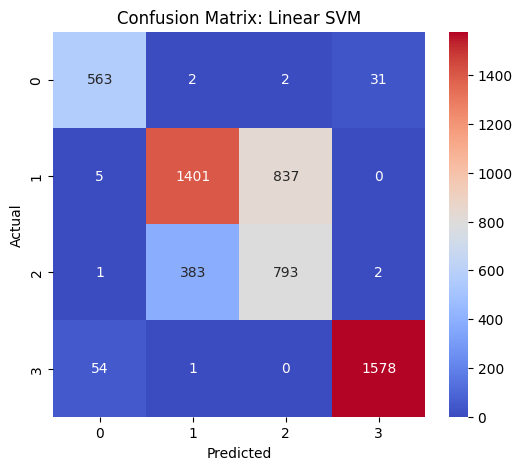

AU ROC Score: 0.9368

--- RBF SVM ---
Fitting 2 folds for each of 2 candidates, totalling 4 fits
Best Parameters: {'C': 10, 'gamma': 'scale'}
Training time in sec: 398.94
Training Accuracy: 0.9094
Testing Accuracy: 0.8323
Testing time in sec: 23.93

Testing prediction metrics:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95       598
           1       0.84      0.75      0.79      2243
           2       0.60      0.73      0.66      1179
           3       0.99      0.98      0.98      1633

    accuracy                           0.83      5653
   macro avg       0.84      0.85      0.85      5653
weighted avg       0.84      0.83      0.84      5653



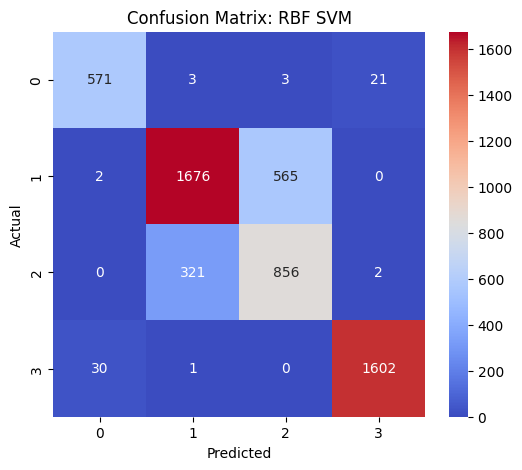

AU ROC Score: 0.9601

--- Polynomial SVM ---
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Best Parameters: {'C': 1}
Training time in sec: 379.12
Training Accuracy: 0.852
Testing Accuracy: 0.7941
Testing time in sec: 12.8

Testing prediction metrics:
               precision    recall  f1-score   support

           0       0.93      0.94      0.94       598
           1       0.81      0.67      0.73      2243
           2       0.53      0.71      0.61      1179
           3       0.98      0.98      0.98      1633

    accuracy                           0.79      5653
   macro avg       0.81      0.82      0.81      5653
weighted avg       0.81      0.79      0.80      5653



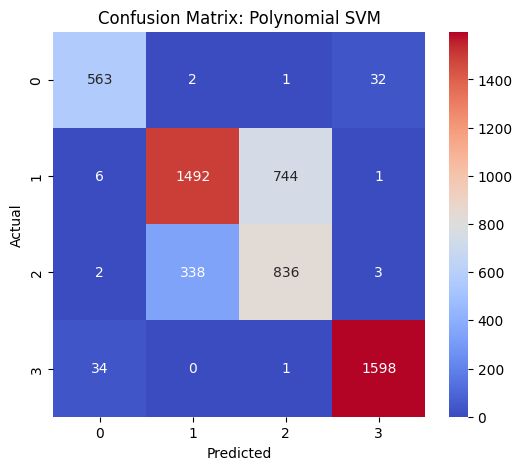

AU ROC Score: 0.9473


In [ ]:
#subset for hyperparameter tuning
Cus_sub_X = cus_Xin_tran_vecw2v_sm[:2000]
Cus_sub_y = cus_Yin_tran_sm[:2000]


Cus_tkt_diffsvm_md = {
    "Linear SVM": {
        "model": Cus_tkt_svm(kernel='linear', probability=True, random_state=42),
        "params": {"C": [1, 10]}
    },
    "RBF SVM": {
        "model": Cus_tkt_svm(kernel='rbf', probability=True, random_state=42),
        "params": {"C": [1, 10], "gamma": ["scale"]}
    },
    "Polynomial SVM": {
        "model": Cus_tkt_svm(kernel='poly', degree=3, probability=True, random_state=42),
        "params": {"C": [1]}
    }
}

for name, config in Cus_tkt_diffsvm_md.items():
    print(f"\n--- {name} ---")

    # GridSearchCV with 2-fold cross-validation
    Cus_gd_tkt = Cus_tkt_gridparam(config["model"], config["params"], cv=2, n_jobs=-1, verbose=1)

    Cus_tra_st = cus_tkt_timetakn.time()
    Cus_gd_tkt.fit(Cus_sub_X, Cus_sub_y)
    Cus_tra_en = cus_tkt_timetakn.time()

    Cus_tra_tm_tkn = Cus_tra_en - Cus_tra_st
    best_params = Cus_gd_tkt.best_params_

    print("Best Parameters:", best_params)

    #Training model with best parameters and full training data
    Cus_final_model = Cus_tkt_svm(
        kernel=config["model"].kernel,
        probability=True,
        random_state=42,
        **best_params
    )

    Cus_tra_st_full = cus_tkt_timetakn.time()
    Cus_final_model.fit(cus_Xin_tran_vecw2v_sm, cus_Yin_tran_sm)
    Cus_tra_en_full = cus_tkt_timetakn.time()
    Cus_tra_tm_tkn_full = Cus_tra_en_full - Cus_tra_st_full

    Cus_Ytra_pdt = Cus_final_model.predict(cus_Xin_tran_vecw2v_sm)
    Cus_tra_accuracy = cus_tkt_acc(cus_Yin_tran_sm, Cus_Ytra_pdt)

    print("Training time in sec:", round(Cus_tra_tm_tkn_full, 2))
    print("Training Accuracy:", round(Cus_tra_accuracy, 4))

    #Testing
    Cus_tst_st = cus_tkt_timetakn.time()
    Cus_Ytst_pdt = Cus_final_model.predict(cus_Xin_tst_vecw2v)
    Cus_tst_en = cus_tkt_timetakn.time()
    Cus_tst_tm_tkn = Cus_tst_en - Cus_tst_st

    print("Testing Accuracy:", round(cus_tkt_acc(cus_Yin_tst, Cus_Ytst_pdt), 4))
    print("Testing time in sec:", round(Cus_tst_tm_tkn, 2))
    print("\nTesting prediction metrics:\n", Cus_tkt_rp(cus_Yin_tst, Cus_Ytst_pdt))

    # Confusion matrix
    cm_tkt_matrix = Cus_tkt_cmatrix(cus_Yin_tst, Cus_Ytst_pdt)
    Cus_tkt_plot.figure(figsize=(6,5))
    Cus_tkt_seabn.heatmap(cm_tkt_matrix, annot=True, fmt='d', cmap='coolwarm')
    Cus_tkt_plot.title(f'Confusion Matrix: {name}')
    Cus_tkt_plot.xlabel('Predicted')
    Cus_tkt_plot.ylabel('Actual')
    Cus_tkt_plot.show()

    #AUC score
    Cus_Y_tkt_prb = Cus_final_model.predict_proba(cus_Xin_tst_vecw2v)
    au_score = Cus_tkt_rocauc(cus_Yin_tst, Cus_Y_tkt_prb, multi_class='ovr')
    print("AU ROC Score:", round(au_score, 4))

# **Multinomial Naive Bayes**

Fitting 2 folds for each of 6 candidates, totalling 12 fits
Best Parameters: {'alpha': 0.1, 'class_prior': None, 'fit_prior': True}
Training time in sec: 0.98
Training Accuracy: 0.7356
Testing Accuracy: 0.7055
Testing time in sec: 0.01

Testing prediction metrics:
               precision    recall  f1-score   support

           0       0.71      0.85      0.78       598
           1       0.73      0.58      0.65      2243
           2       0.41      0.54      0.47      1179
           3       0.95      0.94      0.95      1633

    accuracy                           0.71      5653
   macro avg       0.70      0.73      0.71      5653
weighted avg       0.73      0.71      0.71      5653



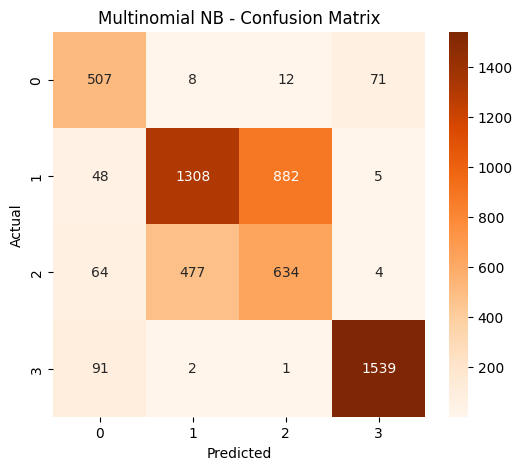

AUC Score: 0.8896


In [ ]:
from sklearn.naive_bayes import MultinomialNB as Cus_tkt_mnb
from sklearn.preprocessing import MinMaxScaler as Cus_tkt_mms

Cus_tkt_mnb_model = Cus_tkt_mnb()

Cus_tkt_mnb_param_grid = {
    "alpha": [0.1, 0.5, 1.0],
    "fit_prior": [True, False],
    "class_prior": [None]
}

Cus_scale_r = Cus_tkt_mms()
cus_Xin_tran_vecw2v_scaled = Cus_scale_r.fit_transform(cus_Xin_tran_vecw2v_sm)
cus_Xin_tst_vecw2v_scaled = Cus_scale_r.transform(cus_Xin_tst_vecw2v)

# GridSearch
Cus_tkt_mnb_grid = Cus_tkt_gridparam(
    estimator=Cus_tkt_mnb_model,
    param_grid=Cus_tkt_mnb_param_grid,
    cv=2,
    n_jobs=-1,
    verbose=1
)

#Training
Cus_tra_st = cus_tkt_timetakn.time()
Cus_tkt_mnb_grid.fit(cus_Xin_tran_vecw2v_scaled, cus_Yin_tran_sm)
Cus_tra_en = cus_tkt_timetakn.time()
Cus_tra_tm_tkn = Cus_tra_en - Cus_tra_st

Cus_Ytra_pdt = Cus_tkt_mnb_grid.predict(cus_Xin_tran_vecw2v_scaled)
Cus_tra_accuracy = cus_tkt_acc(cus_Yin_tran_sm, Cus_Ytra_pdt)

print("Best Parameters:", Cus_tkt_mnb_grid.best_params_)
print("Training time in sec:", round(Cus_tra_tm_tkn, 2))
print("Training Accuracy:", round(Cus_tra_accuracy, 4))

# Testing
Cus_tst_st = cus_tkt_timetakn.time()
Cus_Ytst_pdt = Cus_tkt_mnb_grid.predict(cus_Xin_tst_vecw2v_scaled)
Cus_tst_en = cus_tkt_timetakn.time()

Cus_tst_tm_tkn = Cus_tst_en - Cus_tst_st

print("Testing Accuracy:", round(cus_tkt_acc(cus_Yin_tst, Cus_Ytst_pdt), 4))
print("Testing time in sec:", round(Cus_tst_tm_tkn, 2))
print("\nTesting prediction metrics:\n", Cus_tkt_rp(cus_Yin_tst, Cus_Ytst_pdt))

# Confusion Matrix
cm_tkt_matrix = Cus_tkt_cmatrix(cus_Yin_tst, Cus_Ytst_pdt)
Cus_tkt_plot.figure(figsize=(6,5))
Cus_tkt_seabn.heatmap(cm_tkt_matrix, annot=True, fmt='d', cmap='Oranges')
Cus_tkt_plot.title("Multinomial NB - Confusion Matrix")
Cus_tkt_plot.xlabel('Predicted')
Cus_tkt_plot.ylabel('Actual')
Cus_tkt_plot.show()

# AUROC
Cus_Y_tkt_prb = Cus_tkt_mnb_grid.predict_proba(cus_Xin_tst_vecw2v_scaled)
au_score = Cus_tkt_rocauc(cus_Yin_tst, Cus_Y_tkt_prb, multi_class='ovr')
print("AUC Score:", round(au_score, 4))

# **Bernoulli Naive Bayes**

Fitting 2 folds for each of 18 candidates, totalling 36 fits
Best Parameters: {'alpha': 0.1, 'binarize': 0.0, 'fit_prior': True}
Training time in sec: 5.75
Training Accuracy: 0.7351
Testing Accuracy: 0.7088
Testing time in sec: 0.03

Testing prediction metrics:
               precision    recall  f1-score   support

           0       0.70      0.83      0.76       598
           1       0.72      0.60      0.66      2243
           2       0.43      0.53      0.47      1179
           3       0.95      0.94      0.95      1633

    accuracy                           0.71      5653
   macro avg       0.70      0.73      0.71      5653
weighted avg       0.73      0.71      0.71      5653



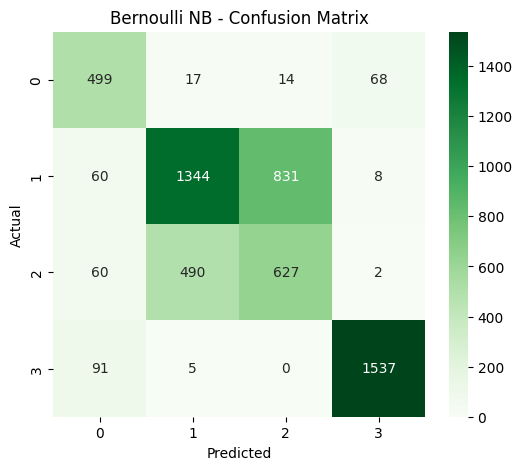

AUC Score: 0.9065


In [ ]:
from sklearn.naive_bayes import BernoulliNB as Cus_tkt_bnb

Cus_tkt_bnb_model = Cus_tkt_bnb()

Cus_tkt_bnb_param_grid = {
    "alpha": [0.1, 0.5, 1.0],
    "binarize": [0.0, 0.5, 1.0],
    "fit_prior": [True, False]
}

# GridSearch
Cus_tkt_bnb_grid = Cus_tkt_gridparam(
    estimator=Cus_tkt_bnb_model,
    param_grid=Cus_tkt_bnb_param_grid,
    cv=2,
    n_jobs=-1,
    verbose=1
)

# Training
Cus_tra_st = cus_tkt_timetakn.time()
Cus_tkt_bnb_grid.fit(cus_Xin_tran_vecw2v_sm, cus_Yin_tran_sm)
Cus_tra_en = cus_tkt_timetakn.time()
Cus_tra_tm_tkn = Cus_tra_en - Cus_tra_st


Cus_Ytra_pdt = Cus_tkt_bnb_grid.predict(cus_Xin_tran_vecw2v_sm)
Cus_tra_accuracy = cus_tkt_acc(cus_Yin_tran_sm, Cus_Ytra_pdt)

print("Best Parameters:", Cus_tkt_bnb_grid.best_params_)
print("Training time in sec:", round(Cus_tra_tm_tkn, 2))
print("Training Accuracy:", round(Cus_tra_accuracy, 4))

# Testing
Cus_tst_st = cus_tkt_timetakn.time()
Cus_Ytst_pdt = Cus_tkt_bnb_grid.predict(cus_Xin_tst_vecw2v)
Cus_tst_en = cus_tkt_timetakn.time()

Cus_tst_tm_tkn = Cus_tst_en - Cus_tst_st

print("Testing Accuracy:", round(cus_tkt_acc(cus_Yin_tst, Cus_Ytst_pdt), 4))
print("Testing time in sec:", round(Cus_tst_tm_tkn, 2))
print("\nTesting prediction metrics:\n", Cus_tkt_rp(cus_Yin_tst, Cus_Ytst_pdt))

# Confusion Matrix
cm_tkt_matrix = Cus_tkt_cmatrix(cus_Yin_tst, Cus_Ytst_pdt)
Cus_tkt_plot.figure(figsize=(6,5))
Cus_tkt_seabn.heatmap(cm_tkt_matrix, annot=True, fmt='d', cmap='Greens')
Cus_tkt_plot.title("Bernoulli NB - Confusion Matrix")
Cus_tkt_plot.xlabel('Predicted')
Cus_tkt_plot.ylabel('Actual')
Cus_tkt_plot.show()

# AUROC
Cus_Y_tkt_prb = Cus_tkt_bnb_grid.predict_proba(cus_Xin_tst_vecw2v)
au_score = Cus_tkt_rocauc(cus_Yin_tst, Cus_Y_tkt_prb, multi_class='ovr')
print("AUC Score:", round(au_score, 4))